In [1]:
import os
import glob

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import ParameterDict

import torchvision
from torchvision import transforms

import kornia as K
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from kAugmentations.kRotation import *
from kAugmentations.kBrightness import *
from kAugmentations.kShearX import *
from kAugmentations.kTranslateX import *
from kAugmentations.kContrast import *

from SingleAugmentationConfig import *
from MultiAugmentationManager import MultiAugmentationManager

import shutil

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

In [2]:
# contrast_config = SingleAugmentationConfig(augmentation_name = 'contrast',
#     main_parameter_name = 'contrast_factor',
#     aug_bounds = (0.0, None),
#     param_linspace = np.linspace(0.0,10.,400),
#     target_param_val = 3.,
#     target_aug_constructor = K.enhance.AdjustContrast,
#     target_aug_constructor_args = {'contrast_factor': None},
#     kAugmentation = kContrast,
#     init_param_val = 1.,
#     criterion_constructor = nn.MSELoss,
#     criterion_constructor_args = {},
#     batch_size = 64,
#     epochs = 1,
#     optimizer_constructor = optim.SGD,
#     optimizer_constructor_args = {
#         'lr': 0.1,
#         'momentum': 0.9,
#     },
#     scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR,
#     scheduler_constructor_args = {
#         'T_max':100,
#         'eta_min':0.1,
#         'verbose':True,
#     },
#     scheduler_warmup = 100,
#     scheduler_freq = 10,
#     use_scheduler=False,
#     early_stopping = 250,
# )

In [3]:
ma_manager = MultiAugmentationManager([contrast_config, translateX_config])

In [4]:
figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{ma_manager.run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{ma_manager.run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)
os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)

In [5]:
batch_size = 64
epochs = 1
early_stopping = 400

criterion_constructor = nn.MSELoss
criterion_constructor_args = {}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    ma_manager.get_target_augmentations()
])

target_transform = transforms.Compose([
    # transforms.ToTensor(),
    target_augmentations
])

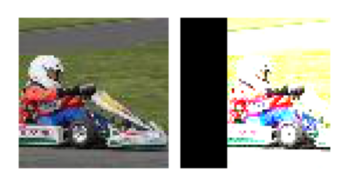

In [7]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)
show_sample(dataset[0])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [8]:
model = ma_manager.get_augmentations_model()
model.to(device)

ImageSequential(
  (kContrast_0): kContrast()
  (kTranslateX_1): kTranslateX()
)

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

kContrast_0.trans_param tensor([1.], device='cuda:0')
kTranslateX_1.trans_param tensor([0.], device='cuda:0')


In [10]:
criterion = criterion_constructor(**criterion_constructor_args)
ma_manager.init_optimizers(model)
ma_manager.init_schedulers()

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 8.0000e+01.


In [11]:
with torch.no_grad():
    img_dict = {
        "source": dataset[0][0],
        "model's output": model(dataset[0][0].unsqueeze(0).to(device)).squeeze(),
        "target": dataset[0][1]
    }
    learning_grid(img_dict, title=ma_manager.grid_title,
                  save=f'{run_figures_dir}/learning_progress/epoch-{0:02}_batch-{0:05}.png')
    
ma_manager.init_params_progress()
ma_manager.update_params_progrogress(model)

In [12]:
losses = []
ma_manager.init_lrs_progress()
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        ma_manager.optimizers_zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        ma_manager.optimizers_step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | ', end='')
            print(f'{ma_manager.get_current_params_str(model)}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0].unsqueeze(0).to(device)).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, title=ma_manager.grid_title,
                              save=f'{run_figures_dir}/learning_progress/epoch-{epoch+1:02}_batch-{i+1:05}.png')
        
        ma_manager.update_lrs_progrogress()
        ma_manager.update_params_progrogress(model)
        ma_manager.schedulers_step(i)

        if i == early_stopping:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.225 | contrast_factor: 1.069, translation: 9.027]
Adjusting learning rate of group 0 to 7.9892e+01.
[Epoch: 1 | Batch: 20 | MSE Loss: 0.110 | contrast_factor: 1.619, translation: 16.549]
Adjusting learning rate of group 0 to 7.9569e+01.
[Epoch: 1 | Batch: 30 | MSE Loss: 0.057 | contrast_factor: 2.184, translation: 21.232]
Adjusting learning rate of group 0 to 7.9033e+01.
[Epoch: 1 | Batch: 40 | MSE Loss: 0.046 | contrast_factor: 2.521, translation: 18.183]
Adjusting learning rate of group 0 to 7.8287e+01.
[Epoch: 1 | Batch: 50 | MSE Loss: 0.023 | contrast_factor: 2.702, translation: 18.145]
Adjusting learning rate of group 0 to 7.7336e+01.
[Epoch: 1 | Batch: 60 | MSE Loss: 0.033 | contrast_factor: 2.795, translation: 22.164]
Adjusting learning rate of group 0 to 7.6185e+01.
[Epoch: 1 | Batch: 70 | MSE Loss: 0.043 | contrast_factor: 2.847, translation: 23.081]
Adjusting learning rate of group 0 to 7.4842e+01.
[Epoch: 1 | Batch: 80 | MSE Loss: 0.062 | 

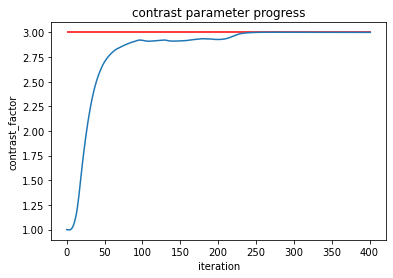

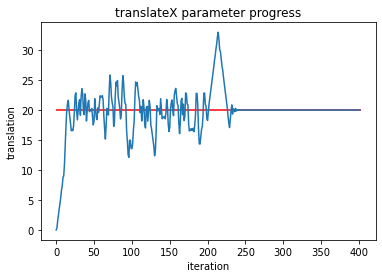

In [13]:
for sa_conf in ma_manager.sa_configs:
    param_progress = ma_manager.params_progress[sa_conf.augmentation_name]
    plt.plot(param_progress, zorder=7)
    plt.hlines(y=sa_conf.target_param_val, xmin=0, xmax=[len(param_progress)], color='r',zorder=5)
    plt.xlabel('iteration')
    plt.ylabel(f'{sa_conf.main_parameter_name}')
    plt.title(f'{sa_conf.augmentation_name} parameter progress')
    plt.savefig(f'{run_figures_dir}/results/parameter_progress__{sa_conf.augmentation_name}.png')
    plt.show()

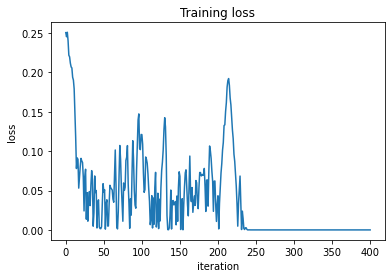

In [14]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

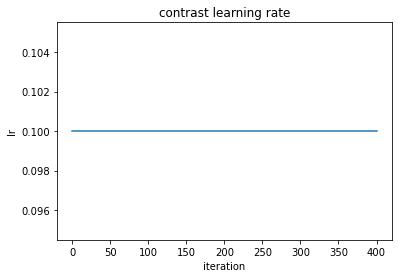

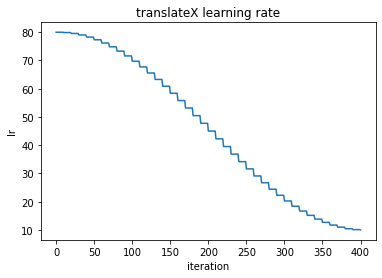

In [15]:
for sa_conf in ma_manager.sa_configs:
    lrs = ma_manager.lrs_progress[sa_conf.augmentation_name]
    plt.plot(lrs)
    plt.title(f'{sa_conf.augmentation_name} learning rate')
    plt.xlabel('iteration')
    plt.ylabel('lr')
    plt.savefig(f'{run_figures_dir}/results/learning_rate__{sa_conf.augmentation_name}.png')
    plt.show()

In [16]:
num_frames = 1000
start_freeze_frames = 20
# filepaths
fp_in = f"{run_figures_dir}/learning_progress/epoch-*"
fp_out = run_gif_name

img_list = [Image.open(f) for f in sorted(glob.glob(fp_in))][:num_frames]
img_list = [img_list[0]]*start_freeze_frames + img_list
imgs = iter(img_list)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=7.5, loop=0)